# Pipeline for Ca-Data-Preprocessing

In [1]:
# import libraries
from skimage import io
import os
import numpy as np
from PyQt5.QtWidgets import QFileDialog, QApplication

from Exp4 import *
# %matplotlib notebook
%matplotlib inline 

In [4]:
working_dir = "C:\\Users\\dburkhardt\\Desktop\\jupyter_notebook_test\\test_data\\calcium_imaging_data\\"
ca_filename = "rec6_Speed_ng20um_20220704_laser19_gain_620_mag2_jf7_5dpf_2fps.TIF"
timeline_filename = "Io.hdf5"
stimulus_filename = "Display.hdf5"

In [5]:
# select files with calcium data (Not sure how well it works in jupyter notebook, crashed on my PC twice)
# filename_ca_data = QFileDialog.getOpenFileName(None,"Select Calcium Recording...",filter="Files(*.tif)")
# ca_movie = np.array(io.imread(filename_ca_data[0]))
# or just:
ca_movie = load_ca_movie(working_dir+ca_filename)

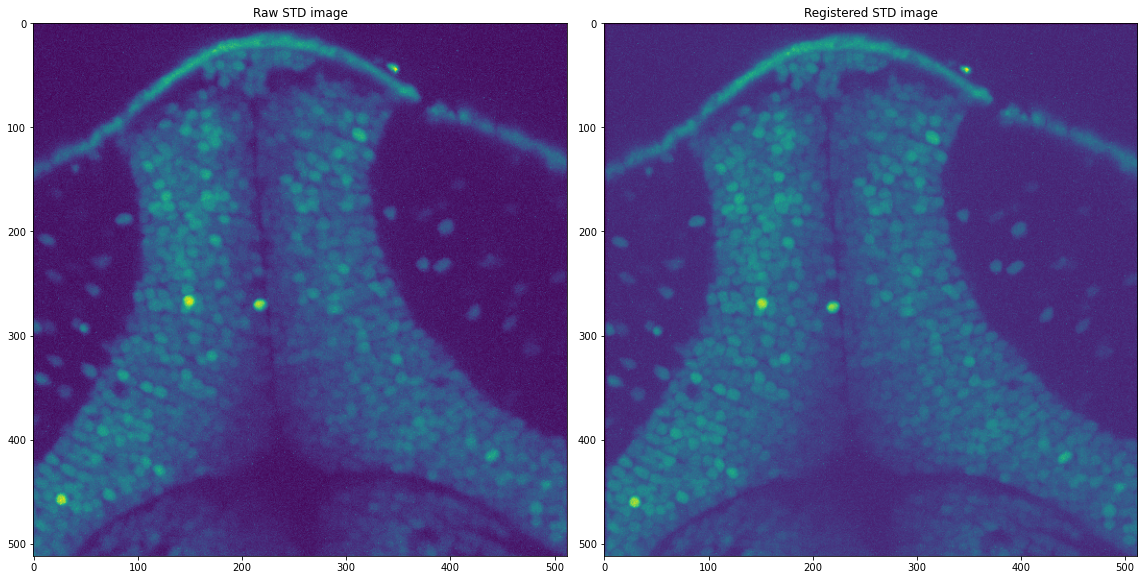

In [6]:
# registration (motion correction) of calcium frames and computation of STD image
reg_frames, std_image = motion_correction(ca_movie, binsize=60, stepsize=40)    #10, 10

C:\Users\dburkhardt\Desktop\jupyter_notebook_test\Exp4.py:162: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)


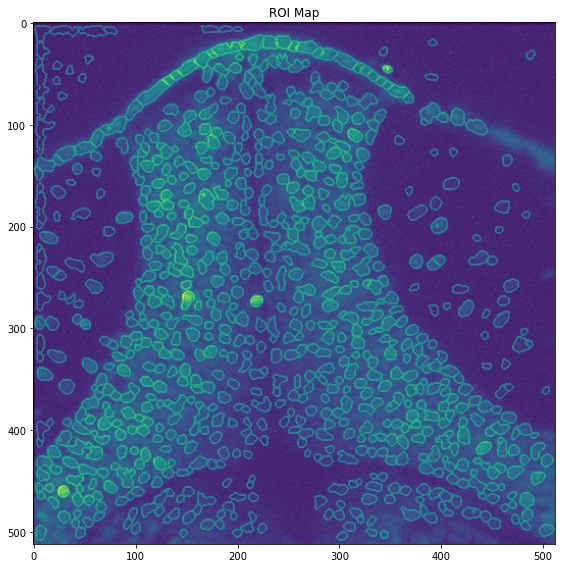

In [7]:
# cell (ROIs) segmentation with watershed algorithm
segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 9,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 20,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1
    }
roi_mask = cell_segmentation(std_image, segmentation_params)

In [8]:
# extract calcium traces for ROIs
raw_ca_traces = extract_calcium_signals(roi_mask, reg_frames, display_traces=False)

In [9]:
# acquire stimulus parameter for each calcium frames
stim_array = align_stimulus_to_ca_frames(timefn=working_dir+timeline_filename,stim_fn=working_dir+stimulus_filename)

In [10]:
print(np.array(raw_ca_traces).shape)
print(stim_array.shape)

(780, 1059)
(1060, 4)


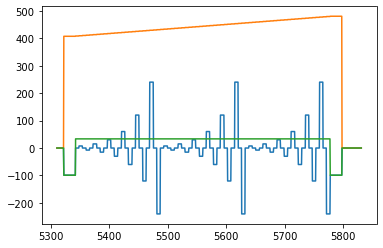

In [11]:
plt.figure()
plt.plot(stim_array['time'],stim_array['speed'])
plt.plot(stim_array['time'],stim_array['phase'])
plt.plot(stim_array['time'],stim_array['spatial_freq'])

In [12]:
roi_id = np.unique(roi_mask)[1:]
formatted = pd.DataFrame(np.array(raw_ca_traces).T,columns=roi_id)
for k,v in stim_array.items():
    formatted["stim_"+k] = v

In [13]:
formatted

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,stim_phase,stim_speed,stim_spatial_freq,stim_time
0,125371,151398,180533,71744,46964,35057,56090,427659,32623,633679,...,237196,48022,81000,56726,79654,66718,0.0,0.0,0.0,5310.754694
1,130908,138528,188664,73092,51417,22796,54203,495210,30092,748867,...,237072,31822,73377,66686,45684,76932,0.0,0.0,0.0,5311.259023
2,130623,155368,173490,66783,45910,26059,51062,481255,34030,666008,...,284422,52953,49843,49720,73025,59610,0.0,0.0,0.0,5311.742843
3,123004,142240,167504,72996,57242,30895,69377,400480,43733,600670,...,289732,42229,59711,50074,67136,61372,0.0,0.0,0.0,5312.217322
4,125238,145858,179315,71170,60861,20906,52409,362350,31119,557443,...,303983,30510,64957,37073,32719,64029,0.0,0.0,0.0,5312.734308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,133406,169484,175122,73956,47350,27949,48629,311729,26670,635177,...,224430,73282,95757,47125,58329,72385,0.0,0.0,0.0,5828.833969
1055,128445,148549,172844,90187,44918,20071,64253,307438,29647,634667,...,203551,76034,49526,43283,44595,61247,0.0,0.0,0.0,5829.292279
1056,126263,147078,175026,93707,41781,27660,56220,354153,32786,504776,...,196188,35858,73249,45973,55993,67488,0.0,0.0,0.0,5829.804687
1057,138751,146211,170796,76420,43541,26282,57497,324820,32015,555877,...,184089,50328,83206,58237,63295,64095,0.0,0.0,0.0,5830.306274


<AxesSubplot:>

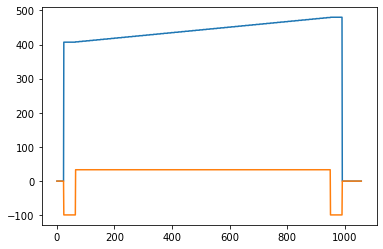

In [14]:
formatted['stim_phase'].plot()
formatted['stim_spatial_freq'].plot()

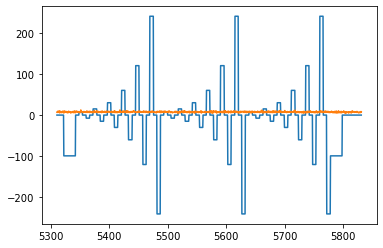

In [15]:
plt.figure()
plt.plot(formatted['stim_time'],formatted['stim_speed'])
plt.plot(formatted['stim_time'],formatted[423]/10000)

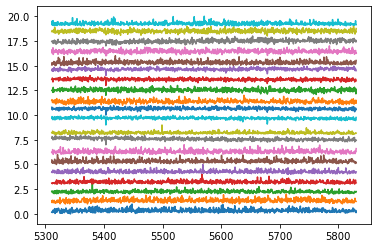

In [17]:
plt.figure()
for i in range(20):
    plt.plot(formatted['stim_time'],rnorm(formatted[i+1].to_numpy())+i)